In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('future.no_silent_downcasting', True)

In [4]:
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [5]:
df = df.drop('Name', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Cabin', axis=1)
test = test.drop('Name', axis=1)
test = test.drop('PassengerId', axis=1)
test = test.drop('Cabin', axis=1)

# Поищем пропуски в данных
df.isna().sum(axis=0)

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [6]:
def replace_mean(table, column):
    val = table[column].mean()
    table[column] = table[column].fillna(val)

def replace_mode(table, column):
    val = table[column].mode()[0]
    table[column] = table[column].fillna(val)

replace_mean(df, 'Age')
replace_mean(df, 'RoomService')
replace_mean(df, 'FoodCourt')
replace_mean(df, 'ShoppingMall')
replace_mean(df, 'Spa')
replace_mean(df, 'VRDeck')

replace_mode(df, 'HomePlanet')
replace_mode(df, 'CryoSleep')
replace_mode(df, 'Destination')
replace_mode(df, 'VIP')

replace_mean(test, 'Age')
replace_mean(test, 'RoomService')
replace_mean(test, 'FoodCourt')
replace_mean(test, 'ShoppingMall')
replace_mean(test, 'Spa')
replace_mean(test, 'VRDeck')

replace_mode(test, 'HomePlanet')
replace_mode(test, 'CryoSleep')
replace_mode(test, 'Destination')
replace_mode(test, 'VIP')

In [7]:
df.isna().sum(axis=0)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [8]:
df["Transported"] = df["Transported"].astype(int)
df["VIP"] = df["VIP"].astype(int)
df["CryoSleep"] = df["CryoSleep"].astype(int)

test["VIP"] = test["VIP"].astype(int)
test["CryoSleep"] = test["CryoSleep"].astype(int)

for col in df.columns:
    if df[col].dtype == 'object':
        print(col)

HomePlanet
Destination


In [9]:
df.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars'], dtype=object)

In [10]:
df['HomePlanet'] = df['HomePlanet'].replace({'Earth' : 0, 'Europa' : 1, 'Mars' : 2})
test['HomePlanet'] = test['HomePlanet'].replace({'Earth' : 0, 'Europa' : 1, 'Mars' : 2})

In [11]:
df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [12]:
df['Destination']= df['Destination'].replace({'TRAPPIST-1e' : 0, 'PSO J318.5-22' : 1, '55 Cancri e' : 2})
test['Destination']= test['Destination'].replace({'TRAPPIST-1e' : 0, 'PSO J318.5-22' : 1, '55 Cancri e' : 2})

In [13]:
df.head().T

,0,1,2,3,4
HomePlanet,1,0,1,1,0
CryoSleep,0,0,0,0,0
Destination,0,0,0,0,0
Age,39.0,24.0,58.0,33.0,16.0
VIP,0,0,1,0,0
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0
Spa,0.0,549.0,6715.0,3329.0,565.0
VRDeck,0.0,44.0,49.0,193.0,2.0


In [14]:
target = 'Transported'

y = df[target].values
X = df.drop(columns=target).values
X_test = test.values

In [15]:
model = DecisionTreeClassifier(max_depth=33)
model.fit(X, y)
pred = model.predict(X_test)
submission = pd.read_csv('./test.csv')[["PassengerId"]]
submission["Transported"] = pred.astype(bool)


In [16]:
submission.to_csv('./submission.csv', index = None)
pd.read_csv("submission.csv")

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [17]:
k = 5
def kfold(X, y, k=5):
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []

    for i in range(k):
        low = int(len(y) * i / k)
        high = int(len(y) * (i + 1) / k)
        y_vals.append(y[low:high])
        X_vals.append(X[low:high, :])


    for i in range(k):
        y_temp = []
        X_temp = []
        for j in range(k):
            if j != i:
                y_temp.append(y_vals[j])
                X_temp.append(X_vals[j])

        y_trains.append(np.concatenate(y_temp))
        X_trains.append(np.vstack(X_temp))
    result = []
    for i in range(k):
        result.append(((X_trains[i], y_trains[i]), (X_vals[i], y_vals[i])))
    return result   

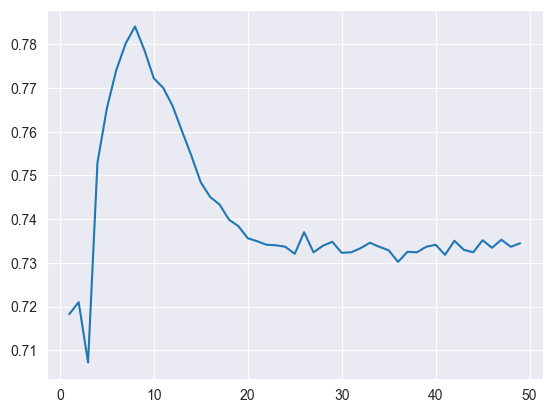

In [18]:
acc_means = []
depths = []
for d in range(1, 50):
    model = DecisionTreeClassifier(max_depth=d)
    accs = []
    for ((X_train, y_train), (X_val, y_val)) in kfold(X, y):
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        accs.append(np.mean(pred == y_val))
    acc_mean = np.mean(accs)
    acc_means.append(acc_mean)
    depths.append(d)

plt.plot(depths, acc_means)

In [19]:
model = DecisionTreeClassifier(max_depth=8)
accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)
acc_mean

0.7822389323175006

In [20]:
model = GradientBoostingClassifier()
accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)
acc_mean

0.7905225983095908

In [21]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
accs_rf = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_val)
    accs_rf.append(np.mean(pred_rf == y_val))
    
acc_mean_rf = np.mean(accs_rf)
acc_mean_rf

0.7792485747920056

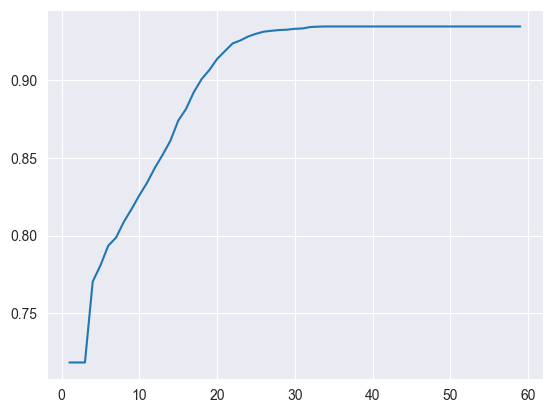

In [22]:
acc_means = []
depths = []
for d in range(1, 60):
    model = DecisionTreeClassifier(max_depth=d)
    accs = []
    model.fit(X, y)
    pred = model.predict(X)
    accs.append(np.mean(pred == y))
    acc_mean = np.mean(accs)
    acc_means.append(acc_mean)
    depths.append(d)

plt.plot(depths, acc_means)